# Movies Recommender System

In this notebook, we will attempt at implementing a few recommendation algorithms (content based, popularity based and collaborative filtering) and try to build an ensemble of these models to come up with our final recommendation system. With us, we have two MovieLens datasets.

* **The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* **The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build a Simple Recommender using movies from the *Full Dataset* whereas all personalised recommender systems will make use of the small dataset (due to the computing power we possess being very limited). As a first step, we will build the simple recommender system.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

## Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre. 

In [2]:
md = pd.read_csv('movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


I use the TMDB Ratings to come up with our **Top Movies Chart.** I will use IMDB's *weighted rating* formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [3]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [4]:
# votes counts column excluding the null values and casting it into integer
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')

# vote averages column exlcuding the null values and casting into float
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('float')

# Calculating average value
C = vote_averages.mean()
C

5.618207215134184

In [5]:
#calculating minimum number of votes requirement for any entry using the 95th percentile

m = vote_counts.quantile(0.95)
m

434.0

In [91]:
# Creating the year column with datetime object for each movie

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: x.year)

In [92]:
# Copying the appropriate columns of metadata to qualified movies with votes_counts >= m

qualified_movies = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
qualified_movies.shape

(2291, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least **434 votes** on TMDB. We also see that the average rating for a movie on TMDB is **5.244** on a scale of 10. **2274** Movies qualify to be on our chart.

In [138]:
# Function that computes the weighted rating of each movie'

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [139]:
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

In [140]:
qualified_movies = qualified_movies.sort_values('score', ascending=False).head(250)

### Top Movies

In [141]:
qualified_movies.head(15)

,title,year,vote_count,vote_average,popularity,genres,score
15651,Inception,2010.0,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.928755
12589,The Dark Knight,2008.0,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.918626
23076,Interstellar,2014.0,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.911049
2870,Fight Club,1999.0,9678,8,63.8696,[Drama],7.897775
4904,The Lord of the Rings: The Fellowship of the Ring,2001.0,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.889160
292,Pulp Fiction,1994.0,8670,8,140.95,"[Thriller, Crime]",7.886457
314,The Shawshank Redemption,1994.0,8358,8,51.6454,"[Drama, Crime]",7.882427
7069,The Lord of the Rings: The Return of the King,2003.0,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.880635
351,Forrest Gump,1994.0,8147,8,48.3072,"[Comedy, Drama, Romance]",7.879536
5876,The Lord of the Rings: The Two Towers,2002.0,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.871988


From the above output we can say that the simple recommender does really well! We all have seen these top rated movies on IMDb top 250 movies list.

We also happen to see that three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors. 

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the **85th** percentile instead of 95. 

In [147]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)
gen_md.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,NaN,Toy Story,False,7.7,5415.0,1995.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,NaN,Toy Story,False,7.7,5415.0,1995.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,NaN,Toy Story,False,7.7,5415.0,1995.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Fantasy


In [13]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['scores'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('scores', ascending=False).head(250)
    
    return qualified

Let us see our method in action by displaying the Top 15 Romance Movies (Romance almost didn't feature at all in our Generic Top Chart despite  being one of the most popular movie genres).

### Top Romance Movies

In [14]:
build_chart('Comedy').head(15)

,title,year,vote_count,vote_average,popularity,scores
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.463024
351,Forrest Gump,1994,8147,8,48.3072,7.963363
1225,Back to the Future,1985,6239,8,25.7785,7.952358
18465,The Intouchables,2011,5410,8,16.0869,7.945207
22841,The Grand Budapest Hotel,2014,4644,8,14.442,7.936384
2211,Life Is Beautiful,1997,3643,8,39.395,7.919430
732,Dr. Strangelove or: How I Learned to Stop Worr...,1964,1472,8,9.80398,7.809073
3342,Modern Times,1936,881,8,8.15956,7.695554
883,Some Like It Hot,1959,835,8,11.8451,7.680781
1236,The Great Dictator,1940,756,8,9.24175,7.651762


The top romance movie according to our metrics is Bollywood's **Dilwale Dulhania Le Jayenge**. Quite a famous one in India.

### Top Action Movies

In [15]:
build_chart('Action').head(15)

,title,year,vote_count,vote_average,popularity,scores
15480,Inception,2010,14075,8,29.1081,7.955099
12481,The Dark Knight,2008,12269,8,123.167,7.948610
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,7.929579
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,7.924031
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,7.918382
256,Star Wars,1977,6778,8,42.1497,7.908327
1154,The Empire Strikes Back,1980,5998,8,19.471,7.896841
4135,Scarface,1983,3017,8,11.2997,7.802046
9430,Oldboy,2003,2000,8,10.6169,7.711649
1910,Seven Samurai,1954,892,8,15.0178,7.426145


The list seems quite reasonable too. So our model works well for different genres too.

## Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves *Inception*, *Titanic* and *The Wolf Of Wall Street*. One inference we can obtain is that the person loves the actor Leonardo Di Caprio. Even if s/he were to access the romance/action chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, we will build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as **Content Based Filtering.**

We will build two Content Based Recommenders based on:
* Movie Overviews and Taglines
* Movie Cast, Crew, Keywords and Genre

Also, as mentioned in the introduction, we will be using a subset of all the movies available to us due to limiting computing power available to us. 

In [16]:
#taking the ids of smaller data set id links of IMDb and TMDb
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [17]:
# Remove rows with bad IDs. (These IDs have bad data)
md = md.drop([19730, 29503, 35587])

In [18]:
md['id'] = md['id'].astype('int')

In [19]:
#declaring new smaller metadata 'smd' which is a subset of 'md'
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

We have **9099** movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

### Movie Description/Plot Based Recommender

In this section, we will build a system that recommends movies that are similar to a particular movie. To achieve this, we will compute pairwise cosine similarity scores for all movies based on their plot descriptions, taglines and recommend movies based on that similarity score threshold.

The plot description is available to us as the overview feature in your metadata dataset. Let's inspect the plots and taglines of a few movies:

In [20]:
#print plot of first 5 movies
md['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [21]:
#print taglines of first 5 movies
md['tagline'].head()

0                                                  NaN
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: tagline, dtype: object

The problem at hand is a Natural Language Processing problem. Hence we need to extract some kind of features from the above text data before we can compute the similarity and/or dissimilarity between them. To do this, we need to compute the word vectors of each overview or document.

As the name suggests, word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other.

We will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before.

In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

- Import the Tfidf module using scikit-learn;
- Remove stop words like 'the', 'an', etc. since they do not give any useful information about the topic;
- Replace not-a-number values with a blank string;
- Finally, construct the TF-IDF matrix on the data.


In [22]:
# Combining the tagline and overview to create an attribute descrption for the dataset
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [23]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [24]:
tfidf_matrix.shape

(9099, 268124)

#### Cosine Similarity

We will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [25]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [26]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 10 most similar movies based on the cosine similarity score.

In [27]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [28]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title):
    
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:31]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

In [29]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [30]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of Nolan and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than **Overview** and **Tagline**. In the next subsection, we will build a more sophisticated recommender that takes **genre**, **keywords**, **cast** and **crew** into consideration.

### Credits, Genres, and Keywords Based Recommender

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [31]:
# Load keywords and credits
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [32]:
# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [33]:
md.shape

(45463, 25)

In [34]:
# Merge keywords and credits into the main metadata dataframe
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [35]:
# Creating the smaller subset for faster computing
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the *feel* of the movie.
2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list. 

In [36]:
# Parse the stringified features into their corresponding python objects
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [37]:
# Function to return the director from the crew
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [38]:
smd['director'] = smd['crew'].apply(get_director)

In [39]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [40]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Our approach to building the recommender is going to be extremely *hacky*. What we plan on doing is creating a metadata dump for every movie which consists of **genres, director, main actors and keywords.** we then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps we follow in the preparation of my genres and credits data:
1. **Strip Spaces and Convert to Lowercase** from all our features. This way, our engine will not confuse between **Johnny Depp** and **Johnny Galecki.** 
2. **Mention Director 3 times** to give it more weight relative to the entire cast.

In [41]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [42]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

#### Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [149]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s1 = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [150]:
s = s.value_counts()
s1 = s1.value_counts()
keyword_occurences = s1.reset_index().values.tolist()
keyword_occurences[:5]

[['independent film', 610],
 ['woman director', 550],
 ['murder', 399],
 ['duringcreditsstinger', 327],
 ['based on novel', 318]]

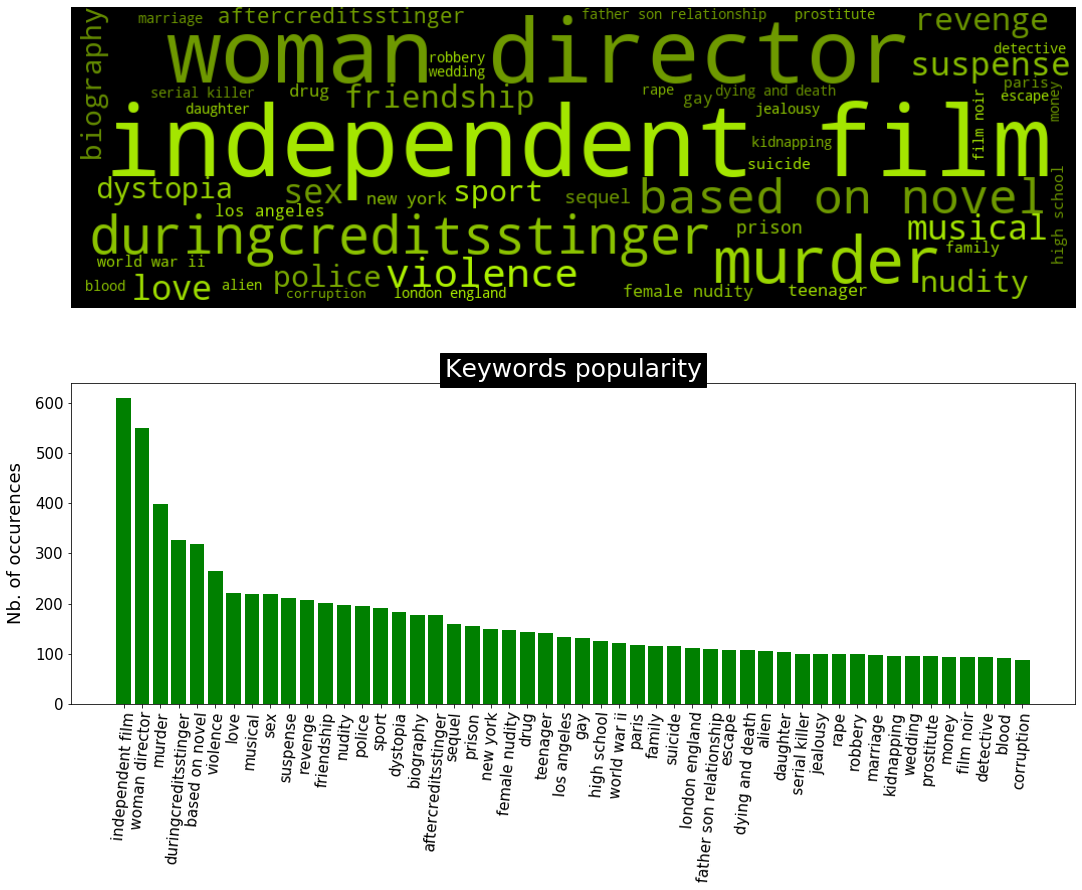

In [89]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()

trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as *Dogs* and *Dog* are considered the same.

In [135]:
md['decade'] = md['year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = md['year'].groupby(md['decade']).apply(get_stats).unstack()

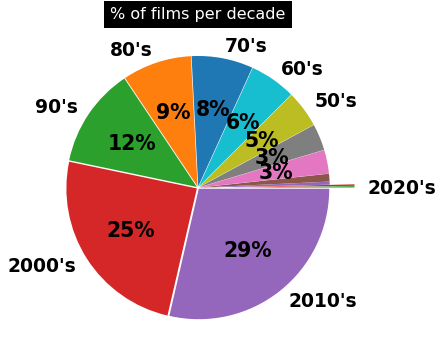

In [136]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(16)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)

ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
md.drop('decade', axis=1, inplace = True)

In [126]:
len(explode), len(sizes)

(12, 16)

In [151]:
s = s[s > 1]

In [152]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [153]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [154]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [155]:
# Create a new soup feature
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [156]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [157]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [158]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

In [159]:
get_recommendations('The Dark Knight').head(15)

8031                 The Dark Knight Rises
6218                         Batman Begins
6623                          The Prestige
2085                             Following
7648                             Inception
4145                              Insomnia
3381                               Memento
8613                          Interstellar
7659            Batman: Under the Red Hood
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
9024    Batman v Superman: Dawn of Justice
4021                  The Long Good Friday
Name: title, dtype: object

The results seem much more satisfactory this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. I enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**. 

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Let us also get recommendations for another movie, **Deadpool** which happens to be my favourite superhero movie.

In [160]:
get_recommendations('Deadpool').head(15)

8869                                Ant-Man
8521                   Thor: The Dark World
7969                           The Avengers
8626    Captain America: The Winter Soldier
8872             Captain America: Civil War
7600                             Iron Man 2
7628                             The A-Team
8392                             Iron Man 3
7923     Captain America: The First Avenger
7286               X-Men Origins: Wolverine
8868                Avengers: Age of Ultron
7009                               Iron Man
8450                          The Wolverine
3049                                  X-Men
8870                         Fantastic Four
Name: title, dtype: object

#### Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that **Batman and Robin** has a lot of similar characters as compared to **The Dark Knight** but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

We will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [161]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['score'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('score', ascending=False)
    return qualified

In [162]:
improved_recommendations('The Dark Knight').head(11)

,title,vote_count,vote_average,year,score
7648,Inception,14075,8,2010,7.928755
8613,Interstellar,11187,8,2014,7.911049
6623,The Prestige,4510,8,2006,7.790919
3381,Memento,4168,8,2000,7.775381
8031,The Dark Knight Rises,9263,7,2012,6.938156
6218,Batman Begins,7511,7,2005,6.924519
1134,Batman Returns,1706,6,1992,5.922571
4145,Insomnia,1181,6,2002,5.897401
2131,Superman,1042,6,1978,5.887738
132,Batman Forever,1529,5,1995,5.136680


Let me also get the recommendations for **Deadpool**, my favorite superhero movie.

In [163]:
improved_recommendations('Deadpool')

,title,vote_count,vote_average,year,score
7969,The Avengers,12000,7,2012,6.951769
7009,Iron Man,8951,7,2008,6.936100
8872,Captain America: Civil War,7462,7,2016,6.924050
8868,Avengers: Age of Ultron,6908,7,2015,6.918320
8846,Kingsman: The Secret Service,6069,7,2015,6.907781
8869,Ant-Man,6029,7,2015,6.907211
8626,Captain America: The Winter Soldier,5881,7,2014,6.905036
7889,X-Men: First Class,5252,7,2011,6.894531
8392,Iron Man 3,8951,6,2013,5.982344
7923,Captain America: The First Avenger,7174,6,2011,5.978221


Unfortunately, **Batman and Robin** does not disappear from our recommendation list. This is probably due to the fact that it is rated a 4, which is only slightly below average on TMDB. It certainly doesn't deserve a 4 when amazing movies like **The Dark Knight Rises** has only a 7. However, there is nothing much we can do about this. Therefore, we will conclude our Content Based Recommender section here and come back to it when we build a hybrid engine.

## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We will not be implementing Collaborative Filtering from scratch. Instead, we will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [164]:
reader = Reader()

In [165]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [166]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [167]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9027  0.9010  0.8999  0.8953  0.8900  0.8978  0.0046  
MAE (testset)     0.6947  0.6920  0.6922  0.6931  0.6849  0.6914  0.0034  
Fit time          3.74    3.76    3.91    3.67    3.96    3.81    0.11    
Test time         0.12    0.45    0.16    0.13    0.11    0.19    0.13    


{'test_rmse': array([0.9027235 , 0.90098483, 0.89994285, 0.89532152, 0.89000558]),
 'test_mae': array([0.69465226, 0.69198747, 0.69215706, 0.69314899, 0.68491716]),
 'fit_time': (3.743985414505005,
  3.7559547424316406,
  3.9125349521636963,
  3.66719126701355,
  3.957383155822754),
 'test_time': (0.12105989456176758,
  0.4478018283843994,
  0.16456055641174316,
  0.1296529769897461,
  0.11170220375061035)}

We get a mean **Root Mean Sqaure Error** of 0.8952 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [168]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user 1 and check the ratings s/he has given.

In [169]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [170]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.4914872805378567, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.563**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

In this section, we will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [171]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [172]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [173]:
indices_map = id_map.set_index('id')

In [174]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [175]:
hybrid(1, 'Iron Man')

,title,vote_count,vote_average,year,id,est
8626,Captain America: The Winter Soldier,5881.0,7.6,2014,100402,3.148630
7889,X-Men: First Class,5252.0,7.1,2011,49538,3.130591
7969,The Avengers,12000.0,7.4,2012,24428,3.057043
4635,X2,3572.0,6.8,2003,36658,2.990544
8712,Guardians of the Galaxy,10014.0,7.9,2014,118340,2.941207
8869,Ant-Man,6029.0,7.0,2015,102899,2.935020
8868,Avengers: Age of Ultron,6908.0,7.3,2015,99861,2.879369
6493,X-Men: The Last Stand,3581.0,6.3,2006,36668,2.873165
7923,Captain America: The First Avenger,7174.0,6.6,2011,1771,2.822341
8872,Captain America: Civil War,7462.0,7.1,2016,271110,2.776195


In [176]:
hybrid(500, 'Iron Man')

,title,vote_count,vote_average,year,id,est
7889,X-Men: First Class,5252.0,7.1,2011,49538,3.483714
6359,Zathura: A Space Adventure,808.0,6.1,2005,6795,3.447696
7969,The Avengers,12000.0,7.4,2012,24428,3.444962
8869,Ant-Man,6029.0,7.0,2015,102899,3.344749
8626,Captain America: The Winter Soldier,5881.0,7.6,2014,100402,3.342542
6493,X-Men: The Last Stand,3581.0,6.3,2006,36668,3.333382
7923,Captain America: The First Avenger,7174.0,6.6,2011,1771,3.327821
7600,Iron Man 2,6969.0,6.6,2010,10138,3.156717
8873,X-Men: Apocalypse,4831.0,6.4,2016,246655,3.112265
8661,Chef,1203.0,7.2,2014,212778,3.095145


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, I have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender:** This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender:** We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine:** We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.
